In [1]:
import os
import random
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from tensorflow.keras.preprocessing import image as image_loader
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_hub as hub
from keras.applications.vgg16 import VGG16, preprocess_input


from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

2023-04-18 18:45:56.840388: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import tensorflow as tf

In [3]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

2023-04-18 18:46:01.306020: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-18 18:46:01.314735: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-18 18:46:01.315097: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [5]:
Image_Width = 224
Image_Height = 224
Image_Size = (Image_Width, Image_Height)
Image_Channels = 3



Batch_Size = 32
lr=1e-2
loss_function = "categorical_crossentropy"
Epochs = 10

In [6]:
main_path = "/tf/dataset/cavity_images"

checkpoint_filepath = "check_point.h5"
tensorboard_log = "logs"
model_save_path = "."

In [7]:
main_datagen = ImageDataGenerator(
    rotation_range=10, # rotation
    width_shift_range=0.2, # horizontal shift
    height_shift_range=0.2, # vertical shift
    zoom_range=0.2, # zoom
    horizontal_flip=True, # horizontal flip
    brightness_range=[0.2,1.2],
    validation_split=0.2,
    preprocessing_function=preprocess_input
) 

train_generator = main_datagen.flow_from_directory(
    directory=main_path,
    target_size=Image_Size,
    subset="training",
    class_mode='categorical',
    color_mode="rgb",
    batch_size=Batch_Size,
    shuffle=True,
    seed=2020 # to make the result reproduciblec
)
test_generator = main_datagen.flow_from_directory(
    directory=main_path,
    target_size=Image_Size,
    subset="validation",
    class_mode='categorical',
    color_mode="rgb",
    batch_size=Batch_Size,
    shuffle=True,
    seed=2020 # to make the result reproduciblec
)
Num_Class=train_generator.num_classes
#class_names =  train_generator.class_names
#sample = next(train_generator)
#print(sample[0].shape)


Found 16059 images belonging to 10 classes.
Found 4008 images belonging to 10 classes.


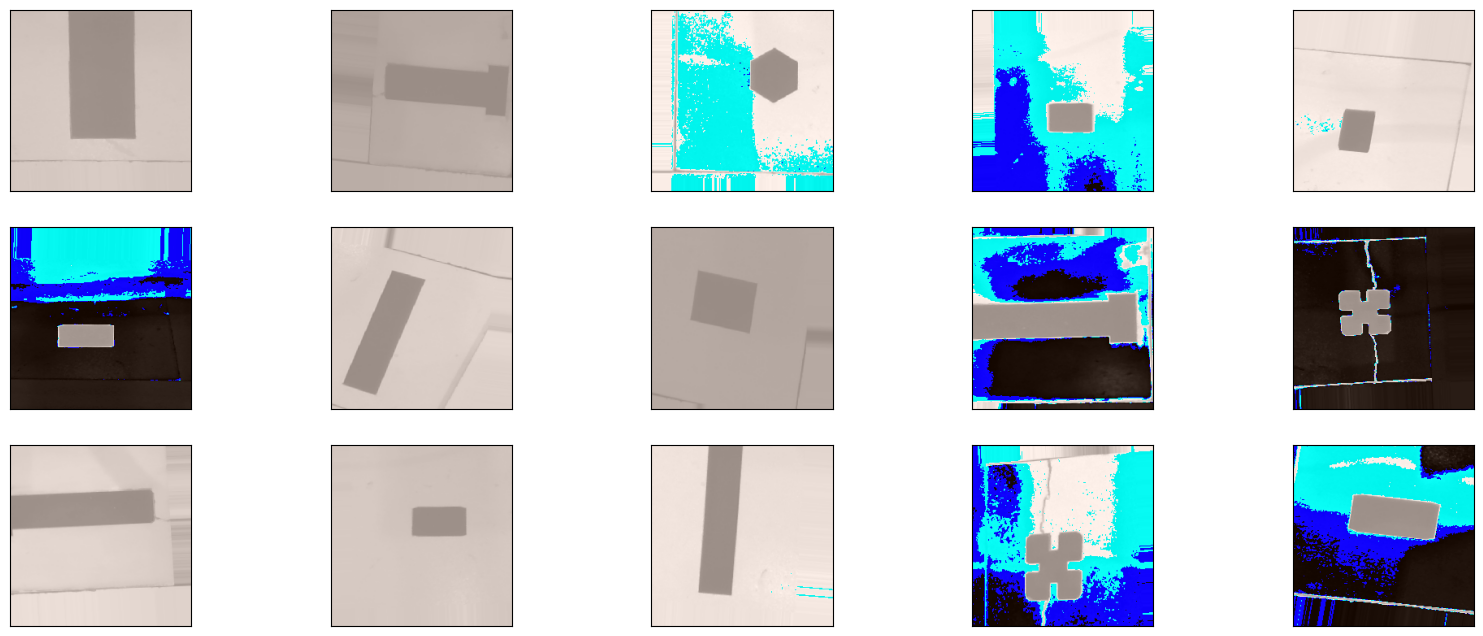

In [8]:
figure = plt.figure(figsize=(20, 8))
for i in range(15) :
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    # Display each image
    image = next(train_generator)[0][-1].astype('uint8')
    #plt.title(class_names[labels[i]])

    ax.imshow(np.squeeze(image))


ReduceLROnPlateau = https://keras.io/api/callbacks/reduce_lr_on_plateau/ #-> reduce lr when no improvment
EarlyStopping     = https://keras.io/api/callbacks/early_stopping/       #-> stop training if no improvment
ModelCheckpoint   = https://keras.io/api/callbacks/model_checkpoint/     #-> save checkpoint
TensorBoard       = https://keras.io/api/callbacks/tensorboard/          #-> tensorboard

In [9]:
earlystop               = EarlyStopping(patience=10)
tensorboard             = TensorBoard(log_dir=tensorboard_log,histogram_freq=1,update_freq='batch',profile_batch=True ,write_graph=True,write_images=True,write_steps_per_second=True)
checkpoint              = ModelCheckpoint(filepath=checkpoint_filepath,save_weights_only=False,monitor='val_accuracy',mode='max',save_best_only=True)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.0001)
callbacks               = [earlystop, learning_rate_reduction,checkpoint,tensorboard]

2023-04-18 18:46:10.446174: I tensorflow/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2023-04-18 18:46:10.446236: I tensorflow/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2023-04-18 18:46:10.446405: I tensorflow/compiler/xla/backends/profiler/gpu/cupti_tracer.cc:1679] Profiler found 1 GPUs
2023-04-18 18:46:10.458362: I tensorflow/tsl/profiler/lib/profiler_session.cc:131] Profiler session tear down.
2023-04-18 18:46:10.458503: I tensorflow/compiler/xla/backends/profiler/gpu/cupti_tracer.cc:1813] CUPTI activity buffer flushed


In [31]:
from tensorflow.keras import layers
import tensorflow as tf

#model_handle = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b0/classification/2"
#model = hub.KerasLayer(model_handle, trainable= False)
#type(model)

def model_builder():
    inputs = layers.Input(shape=(Image_Width, Image_Height, Image_Channels))
    
    #model = EfficientNetV2B0(include_top=False, input_tensor=inputs, weights="imagenet")
    base_vgg = VGG16(include_top=False,
                     input_tensor=inputs,
                     weights='imagenet',
                     input_shape=(Image_Width, Image_Height, Image_Channels))
    # Freeze the pretrained weights
    #model.trainable = True
    base_vgg.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(base_vgg.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(Num_Class, activation="softmax", name="pred")(x)

    # Compile
    base_vgg = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    base_vgg.compile(
        optimizer=optimizer, loss=loss_function, metrics=["accuracy","MeanSquaredError","AUC"]
    )
    return base_vgg
model = model_builder()



2023-04-18 17:09:05.421955: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-18 17:09:05.422168: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-18 17:09:05.422297: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [32]:
history = model.fit(
    train_generator,
    epochs=Epochs,
    validation_data=test_generator,
    validation_steps=test_generator.samples // Batch_Size,
    steps_per_epoch=train_generator.samples // Batch_Size,
    callbacks=callbacks
)

Epoch 1/10


2023-04-18 17:09:08.368461: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-04-18 17:09:08.407596: I tensorflow/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2023-04-18 17:09:08.407631: I tensorflow/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2023-04-18 17:09:10.761156: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-04-18 17:09:12.834814: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.46GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-04-18 17:09:12.834872: W 

  1/501 [..............................] - ETA: 1:16:16 - loss: 2.8503 - accuracy: 0.1250 - mean_squared_error: 0.1042 - auc: 0.5516

2023-04-18 17:09:17.502159: I tensorflow/tsl/profiler/lib/profiler_session.cc:70] Profiler session collecting data.
2023-04-18 17:09:17.503463: I tensorflow/compiler/xla/backends/profiler/gpu/cupti_tracer.cc:1813] CUPTI activity buffer flushed
2023-04-18 17:09:17.537679: I tensorflow/compiler/xla/backends/profiler/gpu/cupti_collector.cc:541]  GpuTracer has collected 3875 callback api events and 2894 activity events. 
2023-04-18 17:09:17.552740: I tensorflow/tsl/profiler/lib/profiler_session.cc:131] Profiler session tear down.


501/501 [==============================] - ETA: 0s - loss: 0.0927 - accuracy: 0.9693 - mean_squared_error: 0.0044 - auc: 0.9988

2023-04-18 17:11:40.559497: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


501/501 [==============================] - 189s 359ms/step - loss: 0.0927 - accuracy: 0.9693 - mean_squared_error: 0.0044 - auc: 0.9988 - val_loss: 0.0124 - val_accuracy: 0.9962 - val_mean_squared_error: 5.7103e-04 - val_auc: 0.9997 - lr: 0.0100
Epoch 2/10
501/501 [==============================] - 173s 344ms/step - loss: 0.0517 - accuracy: 0.9841 - mean_squared_error: 0.0024 - auc: 0.9987 - val_loss: 0.0243 - val_accuracy: 0.9935 - val_mean_squared_error: 0.0011 - val_auc: 0.9991 - lr: 0.0100
Epoch 3/10
501/501 [==============================] - 173s 344ms/step - loss: 0.0696 - accuracy: 0.9842 - mean_squared_error: 0.0026 - auc: 0.9975 - val_loss: 0.0197 - val_accuracy: 0.9950 - val_mean_squared_error: 8.2641e-04 - val_auc: 0.9994 - lr: 0.0100
Epoch 4/10
501/501 [==============================] - ETA: 0s - loss: 0.0533 - accuracy: 0.9877 - mean_squared_error: 0.0020 - auc: 0.9982
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
501/501 [=====================

In [33]:
now = datetime.now()
 
dt_string = now.strftime("%d-%m-%Y_%H-%M-%S")
print(model_save_path+'/'+dt_string+'.h5')
model.save(model_save_path+'/'+dt_string+'_VGG16'+'.h5')

./18-04-2023_17-47-41.h5


In [11]:
from keras.models import load_model
model = load_model('/tf/PPT/bbox_classification/18-04-2023_17-47-41_VGG16.h5')


2023-04-18 18:47:29.834373: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-18 18:47:29.834606: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-18 18:47:29.834740: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [12]:
test_path = "/tf/dataset/cavity_images"

In [13]:
folders = os.listdir(test_path)

images_path = []
for folder in folders :
    
    for image in os.listdir(test_path+'/'+folder):
        #print(image)
        path = test_path+'/'+folder+'/'+image
        #print(path)
        images_path.append(path)


In [14]:
len(images_path)


20067

In [15]:
def image_predict(image_path):
    
    img = image_loader.load_img(image_path,target_size=(224,224))
    img_tensor = image_loader.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)   
    return img_tensor


In [16]:
random.shuffle(images_path)
labels = train_generator.class_indices
print(labels)


{'F20_20_horizontal': 0, 'M20_100_horizontal': 1, 'M20_horizontal': 2, 'M20_vertical': 3, 'M30_horizontal': 4, 'M30_vertical': 5, 'R20_horizontal': 6, 'R20_vertical': 7, 'S40_40_horizontal': 8, 'S40_40_virtical': 9}


In [17]:
labels = dict((v, k) for k, v in labels.items())
print(labels)


{0: 'F20_20_horizontal', 1: 'M20_100_horizontal', 2: 'M20_horizontal', 3: 'M20_vertical', 4: 'M30_horizontal', 5: 'M30_vertical', 6: 'R20_horizontal', 7: 'R20_vertical', 8: 'S40_40_horizontal', 9: 'S40_40_virtical'}


2023-04-18 18:50:12.691908: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600


1/1 [==============================] - 2s 2s/step
<class 'numpy.int64'> 6
1/1 [==============================] - 0s 18ms/step
<class 'numpy.int64'> 1
1/1 [==============================] - 0s 19ms/step
<class 'numpy.int64'> 1
1/1 [==============================] - 0s 18ms/step
<class 'numpy.int64'> 4
1/1 [==============================] - 0s 18ms/step
<class 'numpy.int64'> 3
1/1 [==============================] - 0s 18ms/step
<class 'numpy.int64'> 6
1/1 [==============================] - 0s 21ms/step
<class 'numpy.int64'> 5
1/1 [==============================] - 0s 17ms/step
<class 'numpy.int64'> 9
1/1 [==============================] - 0s 17ms/step
<class 'numpy.int64'> 7
1/1 [==============================] - 0s 17ms/step
<class 'numpy.int64'> 0
1/1 [==============================] - 0s 18ms/step
<class 'numpy.int64'> 1
1/1 [==============================] - 0s 17ms/step
<class 'numpy.int64'> 5
1/1 [==============================] - 0s 17ms/step
<class 'numpy.int64'> 0
1/1 [=========

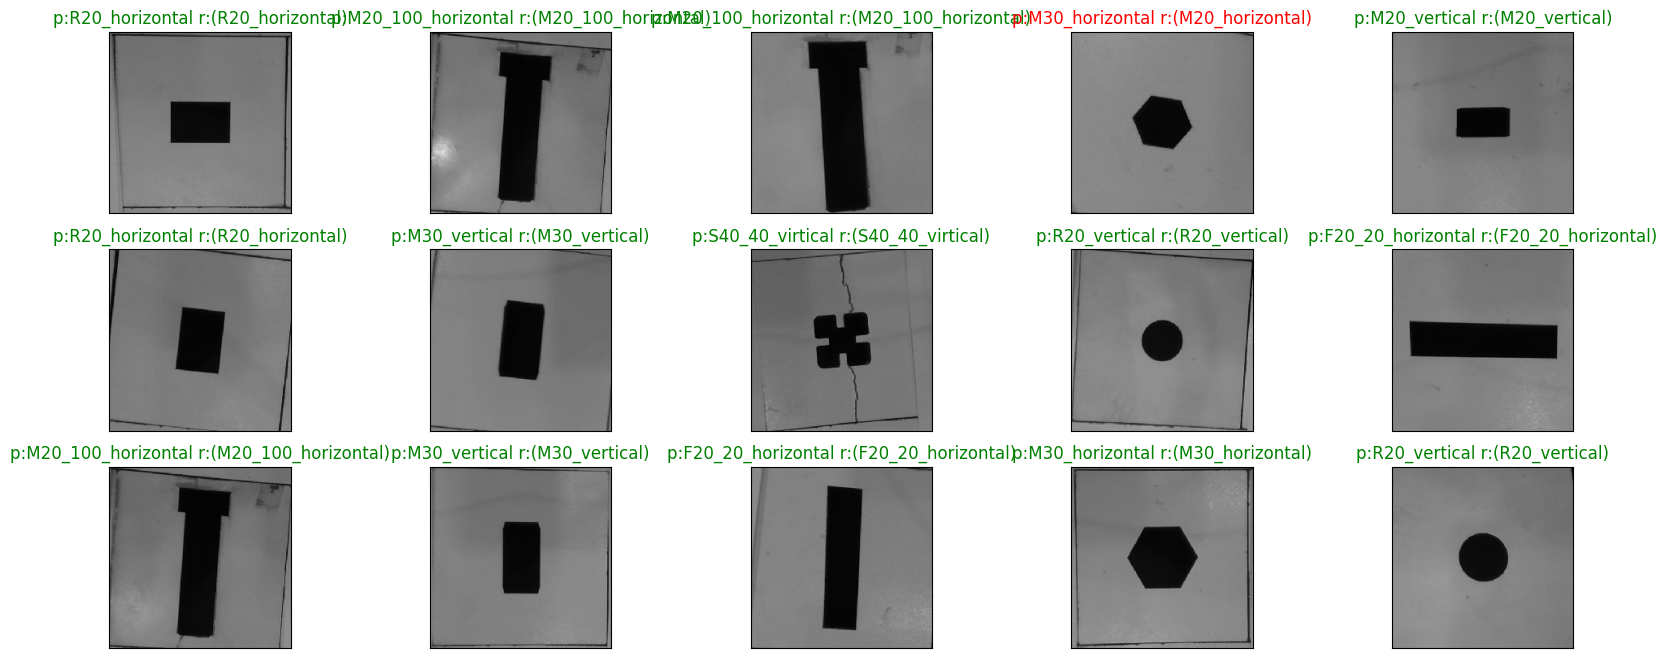

In [18]:
# Plot a random sample of 10 test images, their predicted labels and ground truth
figure = plt.figure(figsize=(20, 8))
for i,img_path in enumerate( images_path[0:15]):
    
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    
    # Display each image
    image = image_loader.load_img(img_path, target_size=Image_Size)
    ax.imshow(np.squeeze(image))
    
    image_to_predict = image_predict(img_path)
    predict = np.argmax(model.predict(image_to_predict))
    print(type(predict), predict)
    #true_label = "porn" if '/p_' in img_path else "normal"
    true_label = '_'.join(img_path.split('/')[-1].split('.')[0].split('_')[0:-1])
    #print(true_label)
    ax.set_title(f"p:{labels[predict]} r:({true_label})", color=("green" if true_label == labels[predict] else "red"))
    #ax.set_title("True" if labels[predict] == true_label else f"p:{labels[predict]} r:({true_label})",
    #             color=("green" if true_label == labels[predict] else "red"))

In [ ]:
labels = {
    0: "F20_20_horizontal",
    1: "M20_100_horizontal",
    2: "M20_horizontal",
    3: "M20_vertical",
    4: "M30_horizontal",
    5: "M30_vertical",
    6: "R20_horizontal",
    7: "R20_vertical",
    8: "S40_40_horizontal",
    9: "S40_40_virtical",
}
y_pred = []
y_test = []


test_path = "/tf/dataset/cavity_images"
folders = os.listdir(test_path)

labels = dict((v, k) for k, v in labels.items())

for folder in folders:
    items = os.listdir(test_path+"/"+folder)
    random.shuffle(items)
    counter = 0
    for item in items:
            image_to_predict = image_predict(test_path+"/"+folder+"/"+item)
            predict = np.argmax(model.predict(image_to_predict))
            real_id = 0 if folder=='normal' else 1
            y_pred.append(predict)
            y_test.append(real_id)

            

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


In [ ]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

disp.plot(cmap=plt.cm.Blues)
plt.show()